# Shutdown

The Shutdown Problem consists of determining the moments to switch off resources in order to save energy. Idle resources consume non-negligible amounts of energy that can be minimized by simply turning them off but the energy/time required to switch On-Off resources can be costly. Therefore, the shutdown policy must balance between performance and energy efficiency.

The objective of this tutorial is to demonstrate how a shutdown policy can be evaluated with Batsim through Batsim-py. It's organized in the following manner. [Section 1](#1.-Simulation-Inputs) presents the simulation input (platform and workload). [Section 2](#2.-Shutdown-Policy) details the shutdown policy implementation. [Section 3](#3.-Simulation-Process) presents the simulation process. Lastly, [Section 4](#4.-Results-Discussion) presents the results and discusses the advantages of each shutdown policy evaluated.

## 1. Simulation Inputs

To evaluate the shutdown policy performance, we must define a platform and a workload. The platform describes the network and resource characteristics (performance, energy consumption, ...). The workload describes job characteristics that will simulate user behavior. Optionally, we can also define some external events to setup when machines become unavailable/available but this isn't necessary and won't be discussed here.

<div class="alert alert-info">

**Note**

To fully understand the platform description, you are encouraged to read the [Simgrid documentation](https://simgrid.org/doc/latest/XML_Reference.html#platform-reference). Information about the workload description can be found in [Batsim documentation](https://batsim.readthedocs.io/en/latest/input-workload.html).
    
</div>

### 1.1. Platform Description

For this tutorial, we define a simple platform with 2 computing resources (hosts) without networking and storage. Moreover, for each host we define 4 power states. These power states will be used to estimate the energy consumption while a host is: off, switching on, switching off, idle, or computing. 

To summarize the platform:

- We define a **"master_host"** (check the ``id`` attribute) to be used by Batsim. This host won't be accounted in the simulation results (only Batsim can use this host).
- For each host, in accordance with the ``sleep_pstates`` property, we define 4 power states:

    - The power state (**0**) determines the power consumption while the host is **sleeping**, which is 9 Watts (W).
    - The power state (**1**) determines the power consumption while the host is **idle** or **computing**, which is 95 W while idle and 190 W while computing.
    - The power state (**2**) determines the power consumption while the host is **switching on** (boot), which is 125 W.
    - The power state (**3**) determines the power consumption while the host is **switching off** (shutdown), which is 101 W.

- Each power state also defines a speed (flop/s) that determines the time a job will take to finish and the time required to completely shutdown or boot up. Example:

    - The **switching off** power state (3) has a speed of 0.1001 flops. Thus, the host takes $\frac{1}{0.1001} = \approx 10$ seconds to shutdown.
    - The **switching on** power state (2) has a speed of 1.0001 flops. Thus, the host takes $\frac{1}{1.0001} = \approx 1$ second to boot.
    - The **computing** power state (1) has a speed of 1000010.0 flops. Thus, if the host is allocated for a job that computes 2Mf, the job will take $\frac{2000000}{1000010} = \approx 1.99$ seconds to complete.


<div class="alert alert-info">

**Note**

When a host is switching On/Off, Batsim automatically starts a job that computes 1 flop in order to simulate the time and costs related to the transition between states. Thus, the speed defined in each transition power state determines the required time to switch.
    
</div>

### 1.2. Workload Description

After describing the platform, we must specify the workload. Let's define a simple workload of 3 jobs and 2 simples profiles with CPU usage only.

To summarize the workload:

- We define 3 jobs to be submitted in different simulation times (1, 3 and 24 seconds).
- We define 2 profiles to specify how many flops/s (``CPU``) the job will compute on each requested hosts (20 Mf and 120 Mf).

## 2. Shutdown Policy

In this tutorial, we'll implement a simple Timeout Policy that turns off hosts if a period ($t$) of idleness is witnessed. Thus, if a host remains idle for $t$ seconds, we turn it off to save energy.

Check the code below:

In [1]:
from batsim_py import SimulatorHandler
from batsim_py.events import HostEvent, SimulatorEvent
from batsim_py.resources import Host

class TimeoutPolicy:
    def __init__(self, t_timeout: float, simulator: SimulatorHandler) -> None:
        self.simulator = simulator
        self.t_timeout = t_timeout        
        self.hosts_idle = {}
        # Subscribe to some events.
        self.simulator.subscribe(SimulatorEvent.SIMULATION_BEGINS, self.on_simulation_begins)
        self.simulator.subscribe(HostEvent.STATE_CHANGED, self.on_host_state_changed)
    
    def on_simulation_begins(self, s: SimulatorHandler) -> None:
        for host in s.platform.hosts:
            if host.is_idle:
                self.hosts_idle[host.id] = s.current_time
                self.setup_callback()
    
    def on_host_state_changed(self, h: Host) -> None:
        if h.is_idle and not h.id in self.hosts_idle:
            self.hosts_idle[h.id] = self.simulator.current_time
            self.setup_callback()
        elif not h.is_idle and h.id in self.hosts_idle:
            del self.hosts_idle[h.id]
    
    def setup_callback(self) -> None:        
        t_next_call = self.simulator.current_time + self.t_timeout
        self.simulator.set_callback(t_next_call, self.callback)
    
    def callback(self, current_time: float) -> None:
        for host_id, t_idle_start in list(self.hosts_idle.items()):
            if  current_time - t_idle_start >= self.t_timeout:
                self.simulator.switch_off([host_id])

We follow an event-based design and the Timeout Policy will act in response to certain events. When the simulation begins, we record the current time for each idle host and set up a callback to be called after ``t_timeout`` seconds. If nothing happens until the callback is called, we switch off hosts that remain idle. Otherwise, if a host switches its state (which dispatches an event) and is no longer idle, we just delete it from our records (``hosts_idle``). The same applies if a host becomes idle, an event is dispatched and we record the current time to set up the callback again.

## 3. Simulation Process

After defining the simulation inputs and the shutdown policies we want to evaluate, it's time to run the simulation and collect some results. 

Check the code below:

In [2]:
from batsim_py import SimulatorHandler
from batsim_py.monitors import SimulationMonitor, HostStateSwitchMonitor, ConsumedEnergyMonitor

def run_simulation(shutdown_policy):
    simulator = SimulatorHandler()
    policy = shutdown_policy(simulator)

    # 1) Instantiate monitors to collect simulation statistics
    sim_mon = SimulationMonitor(simulator)
    host_mon = HostStateSwitchMonitor(simulator)
    e_mon = ConsumedEnergyMonitor(simulator)

    # 2) Start simulation
    simulator.start(platform="platforms/energy_hosts_2.xml",
                    workload="workloads/w_shutdown.json",
                    verbosity="information")

    # 3) Schedule all jobs
    while simulator.is_running:
        # First Fit policy
        for job in simulator.queue:
            available = simulator.platform.get_not_allocated_hosts()
            if job.res <= len(available):
                allocation = [h.id for h in available[:job.res]]
                simulator.allocate(job.id, allocation)
                
        # proceed directly to the next event because the shutdown_policy is event-based.
        simulator.proceed_time()
        
    simulator.close()

    # 4) Return/Dump statistics
    return sim_mon, host_mon, e_mon

sim_none, host_none, e_none = run_simulation(lambda s: None) # Without shutdown
sim_t1, host_t1, e_t1 = run_simulation(lambda s: TimeoutPolicy(1, s)) # Timeout (1)
sim_t5, host_t5, e_t5 = run_simulation(lambda s: TimeoutPolicy(5, s)) # Timeout (5)

To evaluate the effectiveness of a shutdown policy, we run three different experiments: without shutdown policy; with a timeout policy that turns off hosts that remain idle for more than a second; and a timeout policy that turns off hosts that remain idle for more than 5 seconds. 

The simulation process follows the same approach adopted in the [Scheduling tutorial](scheduling.rst) with minor changes. The timeout policy does not exclude the need for a scheduler. To this end, we adopted the First-Fit policy and every job that fits in the number of available resources will immediately start. 

## 4. Results Discussion

We start the discussion by checking the overall performance, check the code below:

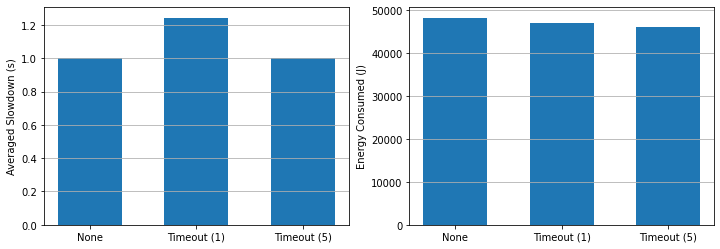

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Read results
none, t_1, t_5 = sim_none.to_dataframe(), sim_t1.to_dataframe(), sim_t5.to_dataframe()
none['name'], t_1['name'], t_5['name'] = "None", "Timeout (1)", "Timeout (5)"
benchmark = pd.concat([none, t_1, t_5], ignore_index=True)

# Slowdown
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.bar('name', 'mean_slowdown', data=benchmark, width=0.6)
plt.grid(axis='y')
plt.ylabel("Averaged Slowdown (s)")

# Energy consumed
plt.subplot(1, 2, 2)
plt.bar('name', 'consumed_joules', data=benchmark, width=0.6)
plt.grid(axis='y')
plt.ylabel("Energy Consumed (J)")

# Show
plt.show()

Considering the averaged slowdown, both the experiment with the Timeout (5) policy and the experiment without a policy gave the same results. We can also observe that the Timeout (1) policy significantly increased the slowdown by $24\%$.

Considering the amount of energy consumed, the Timeout (5) policy achieved the best results. With this policy, we were able to minimize the consumption by $4.7\%$ in comparison to the experiment that does not use a shutdown policy. Moreover, although the Timeout (5) policy needs more time to turn off hosts, it was better than the Timeout (1) policy by $2\%$. The reason behind this is related to the cost of switching On/Off, which consumes both energy and time.  

To better understand these results, we can also use the [evalys package](https://pypi.org/project/evalys/) to plot some charts, check the code below:

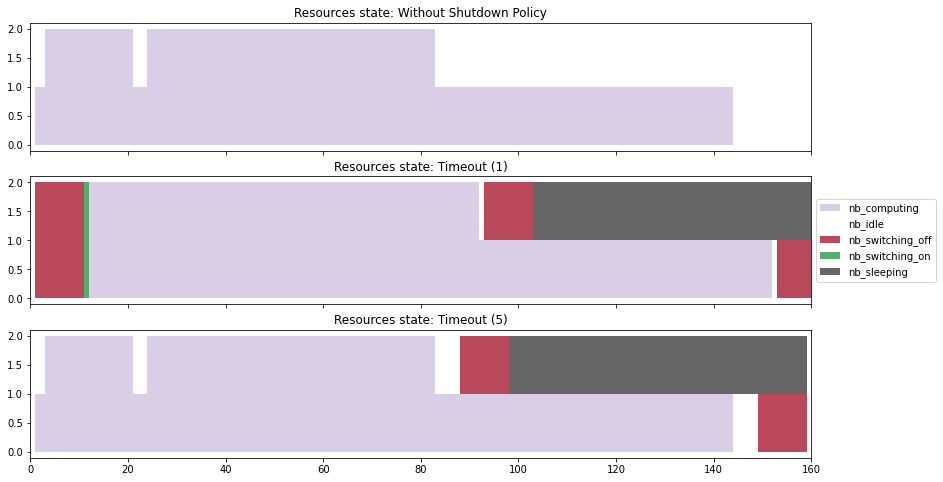

In [4]:
from evalys.mstates import MachineStatesChanges
from evalys.visu.legacy import plot_mstates
    
# Convert monitors to dataframes
none, t_1, t_5 = host_none.to_dataframe(), host_t1.to_dataframe(), host_t5.to_dataframe()

# Plot
_, ax_list = plt.subplots(3, 1, sharex=True, sharey=False, figsize=(14, 8))
plot_mstates(none, ax=ax_list[0], title="Resources state: Without Shutdown Policy")
plot_mstates(t_1, ax=ax_list[1], title="Resources state: Timeout (1)")
ax_list[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
plot_mstates(t_5, ax=ax_list[2], title="Resources state: Timeout (5)")



# Show
plt.xlim(xmin=0, xmax=160)
plt.show()

Looking at the chart, it becomes clear that the shutdown of hosts at time 1 was costly for the Timeout (1) policy. A job was submitted just after the host was turned off, forcing it to boot up right after. If we could know that this would happen, we could overcome this situation but obtaining such information is not straightforward. In this case, it may be worth waiting a little longer before shutting down the hosts.

To clarify further, we can also plot the power consumption over time. Check the code below:

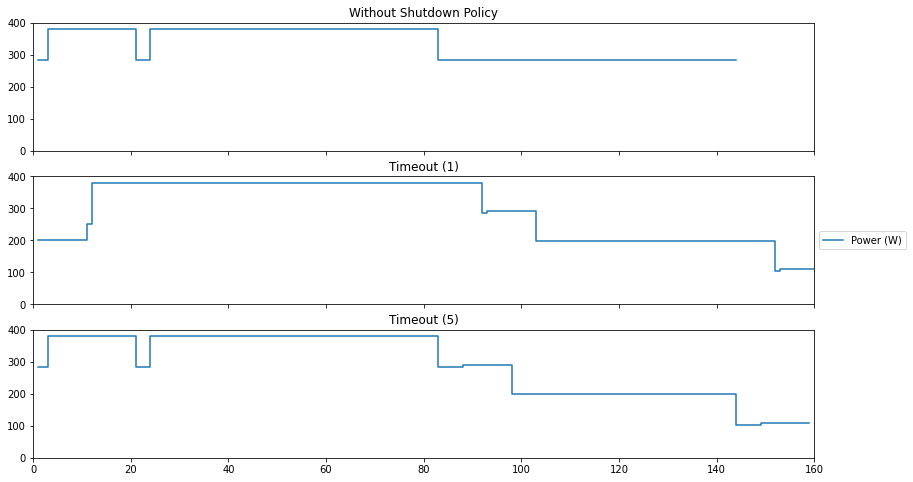

In [5]:
def prepare(dataframe):
    df = dataframe[['time', 'energy']].drop_duplicates(subset='time')
    diff = df.diff(1)
    diff.rename(columns={'time':'time_diff', 'energy':'energy_diff'}, inplace=True)
    concat = pd.concat([df, diff], axis=1)
    concat['power'] = concat['energy_diff'] / concat['time_diff']
    return concat

# Convert monitors to dataframes
none, t_1, t_5 = e_none.to_dataframe(), e_t1.to_dataframe(), e_t5.to_dataframe()

# Prepare data
none, t_1, t_5 = prepare(none), prepare(t_1), prepare(t_5)

# Plot
_, ax_list = plt.subplots(3, 1, sharex=True, sharey=True, figsize=(14, 8))
ax_list[0].plot(none['time'], none['power'], drawstyle='steps-pre')
ax_list[0].set_title('Without Shutdown Policy')

ax_list[1].plot(t_1['time'], t_1['power'], label="Power (W)", drawstyle='steps-pre')
ax_list[1].set_title('Timeout (1)')
ax_list[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax_list[2].plot(t_5['time'], t_5['power'], drawstyle='steps-pre')
ax_list[2].set_title('Timeout (5)')


# Show
plt.xlim(xmin=0, xmax=160)
plt.ylim(ymin=0, ymax=400)
plt.show()

## Next Steps

This tutorial is a very simple example of how to evaluate shutdown policies. Neither the platform nor the workload were realistic. So, as the next steps, you can extend this tutorial to cover other policies, workloads, and platforms.